#### varaibles
- real gdp per capita growth - trend + cycle of real values? diff og gdp real per capita
- inflation = inflation trend + measurement errors???
- short rate = inflation trend + real rate trend 
- long rate = inflation trend + real rate trend + term trend
- inflation expectations??
- growth expextations??
- 

In [8]:
import Pkg
Pkg.activate("../")

include("../src/TCVAR.jl")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


Main.TCVAR

In [9]:
using .TCVAR
using DataFrames, XLSX, TimeSeries
using Statistics
using LinearAlgebra
using Plots


In [43]:
df = DataFrame(XLSX.readtable("../../../data/usa_macro_data.xlsx", "Quarterly", infer_eltypes=true))
data_source = TimeArray(df; timestamp = :observation_date)

gdp = percentchange(data_source[:A939RX0Q048SBEA], :log) .* 400
cpi = percentchange(data_source[:GDPDEF], :log) .* 400

data = merge(gdp, cpi, data_source[[:TB3MS, :GS10]])

presample, data = to(data, Date(1958, 12, 31)), from(data, Date(1959, 01,01))

term =  presample[:GS10] .- presample[:TB3MS]
real_rate = presample[:TB3MS] .- presample[:GDPDEF] 

presample = merge(term, real_rate, presample[[:A939RX0Q048SBEA, :GDPDEF]])


22×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1953-07-01 to 1958-10-01
┌────────────┬────────────┬──────────────┬─────────────────┬──────────┐
│            │ GS10_TB3MS │ TB3MS_GDPDEF │ A939RX0Q048SBEA │ GDPDEF   │
├────────────┼────────────┼──────────────┼─────────────────┼──────────┤
│ 1953-07-01 │       0.96 │     0.294322 │        -4.07719 │  1.66568 │
│ 1953-10-01 │       1.17 │     0.728628 │        -7.96644 │ 0.741372 │
│ 1954-01-01 │       1.38 │    -0.211955 │        -3.63505 │  1.27196 │
│ 1954-04-01 │       1.56 │     0.435756 │        -1.18115 │ 0.354244 │
│ 1954-07-01 │       1.47 │     0.349222 │         2.65269 │ 0.530778 │
│ 1954-10-01 │       1.45 │   -0.0688364 │         5.81037 │  1.08884 │
│ 1955-01-01 │       1.43 │    -0.656424 │         9.59447 │  1.87642 │
│ 1955-04-01 │       1.28 │    -0.154681 │         4.86269 │  1.63468 │
│     ⋮      │     ⋮      │      ⋮       │        ⋮        │    ⋮     │
│ 1957-04-01 │       0.49 │     0.359182 │        -2.50771 │ 

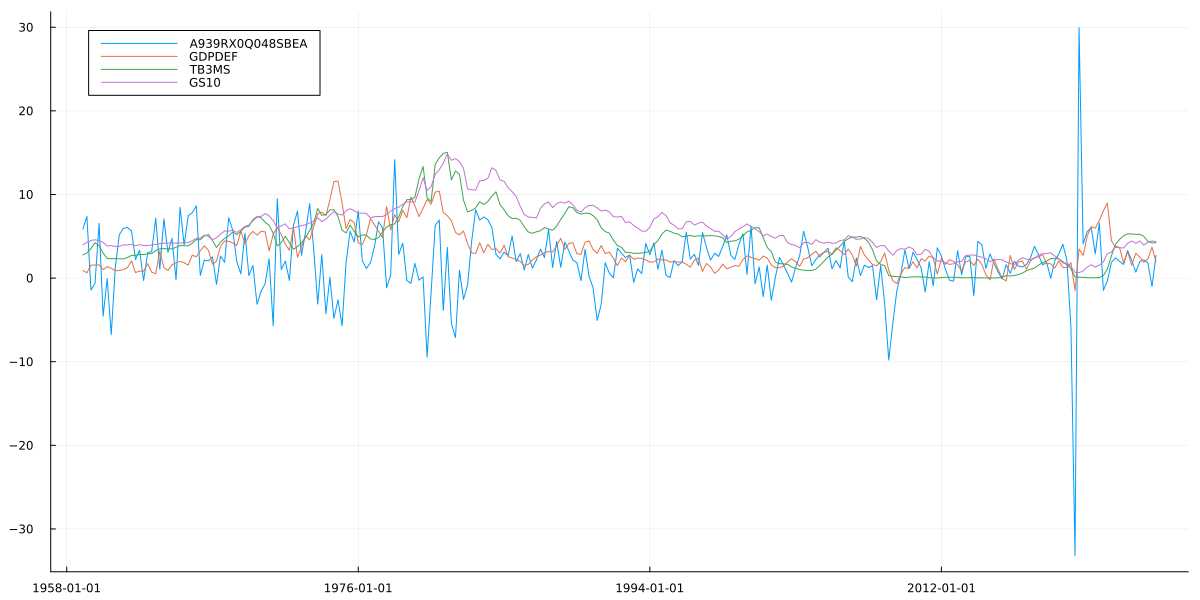

In [44]:
plot(data; size=(1200, 600))

In [46]:
presample_mean = Statistics.mean(presample)
presample_mean = round.(presample_mean, digits=2)
display(presample_mean)

presample_variance = var(presample)
presample_variance = round.(presample_variance, digits=2)
display(presample_variance)
display(presample_variance .^ 2)

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1958-10-01 to 1958-10-01
┌────────────┬────────────┬──────────────┬─────────────────┬────────┐
│            │ GS10_TB3MS │ TB3MS_GDPDEF │ A939RX0Q048SBEA │ GDPDEF │
├────────────┼────────────┼──────────────┼─────────────────┼────────┤
│ 1958-10-01 │       1.02 │        -0.23 │            0.41 │   2.25 │
└────────────┴────────────┴──────────────┴─────────────────┴────────┘

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1958-10-01 to 1958-10-01
┌────────────┬────────────┬──────────────┬─────────────────┬────────┐
│            │ GS10_TB3MS │ TB3MS_GDPDEF │ A939RX0Q048SBEA │ GDPDEF │
├────────────┼────────────┼──────────────┼─────────────────┼────────┤
│ 1958-10-01 │       0.25 │         1.81 │           28.65 │    2.2 │
└────────────┴────────────┴──────────────┴─────────────────┴────────┘

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1958-10-01 to 1958-10-01
┌────────────┬────────────┬──────────────┬─────────────────┬────────┐
│            │ GS10_TB3MS │ TB3MS_GDPDEF │ A939RX0Q048SBEA │ GDPDEF │
├────────────┼────────────┼──────────────┼─────────────────┼────────┤
│ 1958-10-01 │     0.0625 │       3.2761 │         820.822 │   4.84 │
└────────────┴────────────┴──────────────┴─────────────────┴────────┘

In [47]:
n = 4 #number of observatin variables

priors = (
        initial_trend_mean = values(presample_mean)[1,:],
        initial_cycle_mean = zeros(2),
        initial_trend_covariance = diagm([1., 1.]),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2. /20, 1. /20].^2),
        cycle_coeff_mean = zeros(2, 2),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(values(presample_variance)[1,:]), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [1.02, -0.23, 0.41, 2.25], initial_cycle_mean = [0.0, 0.0], initial_trend_covariance = [1.0 0.0; 0.0 1.0], trend_covariance_df = 100, trend_covariance_mean = [0.010000000000000002 0.0; 0.0 0.0025000000000000005], cycle_coeff_mean = [0.0 0.0; 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [0.25 0.0 0.0 0.0; 0.0 1.81 0.0 0.0; 0.0 0.0 28.65 0.0; 0.0 0.0 0.0 2.2], cycle_covariance_df = 6)

In [48]:
trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = TCVAR.gibs_sampler(values(data), priors; burnin = 10_000, n_samples = 10_000, thin=5)

trend_states_mean, trend_states_lower, trend_states_upper = compute_posterior_statistics(trend_states_samples, credible_level=0.95)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

DimensionMismatch: DimensionMismatch: tried to assign 2×2 array to 1×16 destination